In [1]:
%tensorflow_version 1.x
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# magic function
%matplotlib inline

import collections

TensorFlow 1.x selected.


In [0]:
data1= pd.read_csv("/content/drive/My Drive/Colab Notebooks/deep data/Questions.csv",encoding='iso-8859-1')

In [3]:
data1.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [0]:
data2= pd.read_csv("/content/drive/My Drive/Colab Notebooks/deep data/Tags.csv",encoding='iso-8859-1')

In [5]:
data2.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [0]:

def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


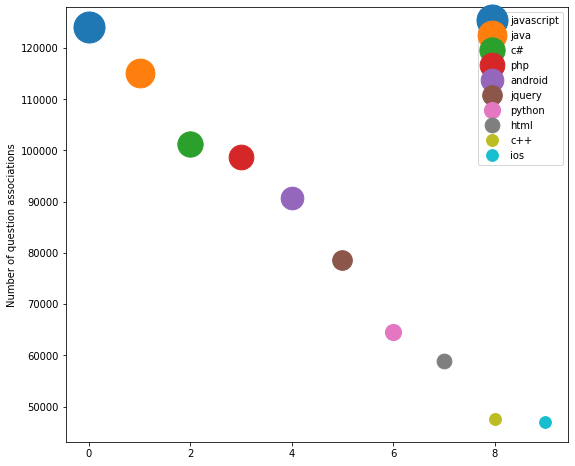

In [7]:
tagCount =  collections.Counter(list(data2['Tag'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

In [0]:
top10=['javascript','java','c#','php','android','jquery','python','html','c++','ios']

In [9]:
tag_top10= data2[data2.Tag.isin(top10)]
print (tag_top10.shape)
tag_top10.head()

(826739, 2)


,Id,Tag
14,260,c#
18,330,c++
28,650,c#
35,930,c#
39,1010,c#


In [0]:
def add_tags(question_id):
    return tag_top10[tag_top10['Id'] == question_id['Id']].Tag.values

top10 = tag_top10.apply(add_tags, axis=1)

In [11]:
len(top10),tag_top10.shape

(826739, (826739, 2))

In [12]:
tag_top10=pd.concat([tag_top10, top10.rename('Tags')], axis=1)
tag_top10.head()

,Id,Tag,Tags
14,260,c#,[c#]
18,330,c++,[c++]
28,650,c#,[c#]
35,930,c#,[c#]
39,1010,c#,[c#]


In [13]:
tag_top10.drop(["Tag"], axis=1, inplace=True)
tag_top10.shape

(826739, 2)

In [0]:
top10_tags=tag_top10.loc[tag_top10.astype(str).drop_duplicates().index]

In [15]:
data1.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [0]:
data1= data1.drop(['OwnerUserId','CreationDate','ClosedDate','Score'],axis=1)

In [17]:
total=pd.merge(data1, top10_tags, on='Id')
print(total.shape)
total.head()

(706336, 4)


,Id,Title,Body,Tags
0,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,[c#]
1,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,[c++]
2,650,Automatically update version number,<p>I would like the version property of my app...,[c#]
3,930,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,[c#]
4,1010,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,[c#]


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, GRU ,concatenate
from keras.models import Model


Using TensorFlow backend.


In [19]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(total.Tags)
labels = multilabel_binarizer.classes_
labels

array(['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript',
       'jquery', 'php', 'python'], dtype=object)

In [0]:
train,test=train_test_split(total[:550000],test_size=0.25,random_state=24)

In [21]:

train.shape,test.shape

((412500, 4), (137500, 4))

In [0]:
X_train_t=train['Title']
X_train_b=train['Body']
y_train=multilabel_binarizer.transform(train['Tags'])
X_test_t=test['Title']
X_test_b=test['Body']
y_test=multilabel_binarizer.transform(test['Tags'])

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
sent_lens_t=[]
for sent in train['Title']:
    sent_lens_t.append(len(word_tokenize(sent)))
max(sent_lens_t)

59

In [25]:
np.quantile(sent_lens_t,0.97)

18.0

In [0]:
max_len_t = 18
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_t)
sequences_train_t = tok.texts_to_sequences(X_train_t)

In [27]:
vocab_len_t=len(tok.index_word.keys())
vocab_len_t

68969

In [28]:
sequences_matrix_train_t = sequence.pad_sequences(sequences_train_t,maxlen=max_len_t)
sequences_matrix_train_t

array([[    0,     0,     0, ...,     1,   957,   197],
       [    0,     0,     0, ...,  9081,    45,   533],
       [    0,     0,     0, ...,   147,     8,   230],
       ...,
       [    0,     0,     0, ...,    10,    71,  2985],
       [    0,     0,     0, ...,     2,    18,    75],
       [    0,     0,     0, ..., 11009,   809,   267]], dtype=int32)

In [0]:
sequences_test_t = tok.texts_to_sequences(X_test_t)
sequences_matrix_test_t = sequence.pad_sequences(sequences_test_t,maxlen=max_len_t)

In [30]:
sequences_matrix_train_t.shape,sequences_matrix_test_t.shape,y_train.shape,y_test.shape

((412500, 18), (137500, 18), (412500, 10), (137500, 10))

In [31]:
sent_lens_b=[]
for sent in train['Body']:
    sent_lens_b.append(len(word_tokenize(sent)))
max(sent_lens_b)

20901

In [32]:
np.quantile(sent_lens_b,0.90)

667.0

In [0]:
max_len_b = 600
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_b)
sequences_train_b = tok.texts_to_sequences(X_train_b)

In [34]:
vocab_len_b =len(tok.index_word.keys())
vocab_len_b

1361145

In [35]:
sequences_matrix_train_b = sequence.pad_sequences(sequences_train_b,maxlen=max_len_b)
sequences_matrix_train_b

array([[  0,   0,   0, ...,  96,   4,   9],
       [  0,   0,   0, ..., 847,   4,   1],
       [  0,   0,   0, ...,  90,   4,   9],
       ...,
       [  0,   0,   0, ...,  75, 709,   1],
       [  0,   0,   0, ...,  65,  13,   1],
       [  0,   0,   0, ..., 207,  13,   1]], dtype=int32)

In [0]:
sequences_test_b = tok.texts_to_sequences(X_test_b)
sequences_matrix_test_b = sequence.pad_sequences(sequences_test_b,maxlen=max_len_b)

In [37]:
sequences_matrix_train_t.shape,sequences_matrix_train_b.shape,y_train.shape

((412500, 18), (412500, 600), (412500, 10))

In [38]:
sequences_matrix_test_t.shape,sequences_matrix_test_b.shape,y_test.shape

((137500, 18), (137500, 600), (137500, 10))

In [0]:
def RNN():
    # Title Only
    title_input = Input(name='title_input',shape=[max_len_t])
    title_Embed = Embedding(vocab_len_t+1,2000,input_length=max_len_t,mask_zero=True,name='title_Embed')(title_input)
    gru_out_t = GRU(300)(title_Embed)
    # auxiliary output to tune GRU weights smoothly 
    auxiliary_output = Dense(10, activation='sigmoid', name='aux_output')(gru_out_t)   
    
    # Body Only
    body_input = Input(name='body_input',shape=[max_len_b]) 
    body_Embed = Embedding(vocab_len_b+1,170,input_length=max_len_b,mask_zero=True,name='body_Embed')(body_input)
    gru_out_b = GRU(200)(body_Embed)
    
    # combined with GRU output
    com = concatenate([gru_out_t, gru_out_b])
    
    # now the combined data is being fed to dense layers
    dense1 = Dense(400,activation='relu')(com)
    dp1 = Dropout(0.5)(dense1)
    bn = BatchNormalization()(dp1) 
    dense2 = Dense(150,activation='relu')(bn)
    
    main_output = Dense(10, activation='sigmoid', name='main_output')(dense2)
    
    model = Model(inputs=[title_input, body_input],outputs=[main_output, auxiliary_output])
    return model

In [40]:
model = RNN()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 18)           0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 600)          0                                            
__________________________________________________________________________________________________
title_Embed (Embedding)         (None, 18, 2000)     137940000   title_input[0][0]                
__________________________________________________________________________________________________
body_Embed (Embe

In [0]:
model.compile(optimizer='adam',loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [42]:
results=model.fit({'title_input': sequences_matrix_train_t, 'body_input': sequences_matrix_train_b},
          {'main_output': y_train, 'aux_output': y_train},
          validation_data=[{'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},
          {'main_output': y_test, 'aux_output': y_test}],
          epochs=5, batch_size=800)



Train on 412500 samples, validate on 137500 samples
Epoch 1/5
412500/412500 [==============================] - 794s 2ms/step - loss: 2.3290 - main_output_loss: 1.0485 - aux_output_loss: 1.2801 - main_output_accuracy: 0.7203 - aux_output_accuracy: 0.6621 - val_loss: 1.7878 - val_main_output_loss: 0.7414 - val_aux_output_loss: 1.0462 - val_main_output_accuracy: 0.8242 - val_aux_output_accuracy: 0.7275
Epoch 2/5
412500/412500 [==============================] - 789s 2ms/step - loss: 1.5940 - main_output_loss: 0.6551 - aux_output_loss: 0.9390 - main_output_accuracy: 0.8447 - aux_output_accuracy: 0.7591 - val_loss: 1.7091 - val_main_output_loss: 0.6651 - val_aux_output_loss: 1.0439 - val_main_output_accuracy: 0.8385 - val_aux_output_accuracy: 0.7267
Epoch 3/5
412500/412500 [==============================] - 785s 2ms/step - loss: 1.4058 - main_output_loss: 0.5537 - aux_output_loss: 0.8522 - main_output_accuracy: 0.8656 - aux_output_accuracy: 0.7777 - val_loss: 1.7516 - val_main_output_loss: 

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/deep data/Proj_3DL.h5')

In [44]:
(predicted_main, predicted_aux)=model.predict({'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},verbose=1)

137500/137500 [==============================] - 1404s 10ms/step


In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/deep data/Proj_3DL_2552.h5')